In [1]:
import os
import scipy.stats
import pandas as pd
import numpy as np
import math
import pprint
import zipfile
import json
from prettytable import PrettyTable
from operator import itemgetter
import matplotlib.pyplot as plt

## Computing number of samples as a function of epsilon and the other way around

In [2]:
def compute_n(c, delta, epsilon, size_of_market):
    return (c / epsilon) * (c / epsilon) * 0.5 * math.log((2 * size_of_market) / delta)

In [3]:
def compute_eps(c, delta, size_of_market, number_of_samples):
    return c * math.sqrt((math.log((2.0 * size_of_market) / delta)) / (2.0 * number_of_samples))

In [4]:
candidate_eps = [10.0 / (2 ** i) for i in range(0, 4)]
for eps in candidate_eps:
    m_eps = compute_n(402, 0.1, eps, 4480)
    print(f"{eps} \t {[int(m_eps /4) , int(m_eps / 2), int(m_eps), int(2 * m_eps)]}")

10.0 	 [2303, 4606, 9213, 18427]
5.0 	 [9213, 18427, 36855, 73711]
2.5 	 [36855, 73711, 147423, 294846]
1.25 	 [147423, 294846, 589692, 1179384]


### Testing eps to n and n to eps functions

In [5]:
c = 2
delta = 0.1
epsilon = 1.0
size_of_market = 4480
n = compute_n(c, delta, epsilon, size_of_market)
assert epsilon == compute_eps(c, delta, size_of_market, n)
assert n == compute_n(c, delta, epsilon, size_of_market)

## Compute Statistics from LSVM worlds

In [6]:
def read_json_from_zip(json_world_loc):
    """
    Reads a JSON file from a zip file.
    """
    with zipfile.ZipFile(json_world_loc, "r") as z:
        for filename in z.namelist():
            with z.open(filename) as f:
                data = json.loads(f.read().decode("utf-8"))
    return data

In [7]:
def compare_ea_eap(model_type, world_number, epsilon):

    # Location of the results. 
    loc = f"../value_models_experiments/{model_type}/worlds_results/world{world_number}/eps_{eps}/"
    
    # Read EAP data.
    bidders_final_values_df = pd.read_csv(f"{loc}bidders_final_values.csv")
    eap_samples = bidders_final_values_df['n'].sum()
    
    # Compute EA data.
    bidders_summary_df = pd.DataFrame([(int(data['id']), str(data['preferred_licences'])) 
                                       for data in read_json_from_zip(f"../value_models_experiments/{model_type}/worlds/world{world_number}.zip")['bidder_values']],
                                      columns = ['bidder', 'preferred_licences'])

    params_csv = pd.read_csv(f"{loc}params.csv")
    c, delta, eps_eap = int(params_csv.iloc[3]['value']), sum(eval(params_csv.iloc[1]['value'])), float(params_csv.iloc[6]['value'])
    size_of_market = sum([2 ** len(eval(row[2])) for row in bidders_summary_df.itertuples()])
    ea_samples = compute_n(c, delta, epsilon, size_of_market) * size_of_market
    
    # Make sure that the epsilon given as parameters coincides with the epsilon actually needed by EA. 
    assert math.isclose(epsilon, compute_eps(c, delta, size_of_market, ea_samples / size_of_market))
    
    return [world_number, 
            c, 
            delta, 
            epsilon, 
            eps_eap, 
            size_of_market,
            ea_samples, 
            eap_samples,
            (eap_samples / ea_samples) * 100.0]

In [8]:
def construct_ea_eap_ptable(results, sort_key=7):
    # Sort by desired key
    results = sorted(results, key=itemgetter(sort_key))
    # Construct ptable
    results_ptable = PrettyTable()
    results_ptable.field_names = ['world', 'c', 'delta', 'epsilon', 'eap_epsilon', 'size_of_market', 'ea', 'eap', 'ratio']
    results_ptable.align["ea"] = "r"
    results_ptable.align["eap"] = "r"

    for r in results:
        results_ptable.add_row([r[0], 
                                r[1], 
                                r[2], 
                                f"{r[3] : .4f}", 
                                f"{r[4] : .4f}", 
                                f"{r[5] : ,}", 
                                f"{r[6] : ,.0f}", 
                                f"{r[7] : ,.0f}", 
                                f"{r[8] : .4f}"])
    return results_ptable

In [9]:
def compute_conf_interval(sample, confidence_level = 0.95):
    degrees_freedom = len(sample) - 1
    sample_mean = np.mean(sample)
    sample_standard_error = scipy.stats.sem(sample)
    lb, ub = scipy.stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

    return sample_mean, lb, ub, (ub - lb)/2

## Table Data

In [10]:
# Note: GSVM has fixed market sizes, hence, EA has a deterministic number of samples, hence, width of CI is zero. 
configurations = {
    'GSVM' :  {'samples' : range(0, 40)} ,
    'LSVM' :  {'samples' : range(0, 50)} ,
                 }
epsilons = [1.25, 2.5, 5.0, 10.0]

# Parameters for the table. 
domain = 'GSVM'
with_ci = True
scaling = 1000000
    
print(f"{domain}")
for eps in epsilons:
    data = [compare_ea_eap(domain, i, float(eps)) 
            for i in configurations[domain]['samples']]
    eps_eap = [data[4] for data in data]
    num_samples_eap = [data[7] for data in data]
    size_of_market = [compute_n(c=int(data[1]),
                                delta=float(data[2]), 
                                epsilon=float(eps), 
                                size_of_market = int(data[5])) * int(data[5]) for data in data]
    
    # Compute confidence intervals. 
    mean_eap_eps, lb_eap_eps, ub_eap_eps, width_ci_eap_eps = compute_conf_interval(eps_eap)
    mean_eap, lb_eap, ub_eap, width_ci_eap = compute_conf_interval(num_samples_eap)
    mean_ea, lb_ea, ub_ea, width_ci_ea = compute_conf_interval(size_of_market)
    
    # Prints. 
    #print(f"{eps} ", end='')
    if mean_ea < mean_eap:
        if not with_ci:
            # No confidence intervals
            print(f"& ${{\\bf {mean_ea / scaling :,.0f}}}$ \t & ", end='')
            print(f"${mean_eap / scaling :,.0f}$ \t& ", end='')
            print(f"${mean_eap_eps :.2f}$ ")
        else:
            # With confidence intervals
            #print(f"& ${{\\bf {mean_ea / scaling :,.0f}}}$ & ", end='')
            print(f"& ${{\\bf {mean_ea / scaling :,.0f} \pm {width_ci_ea / scaling :,.0f}}}$ & ", end='')
            print(f"${mean_eap / scaling :,.0f} \pm {width_ci_eap / scaling :,.0f}$ &", end='')
            print(f"${mean_eap_eps :.2f} \pm {width_ci_eap_eps :.2f}$ ")
    else:
        if not with_ci:
            # No confidence intervals
            print(f"& ${mean_ea / scaling :,.0f}$ \t & ", end='')
            print(f"${{\\bf {mean_eap / scaling :,.0f}}}$  \t& ", end='')
            print(f"${mean_eap_eps :.2f}$ ")
        else:
            # With confidence intervals
            #print(f"& ${mean_ea / scaling :,.0f}$ & ", end='')
            print(f"& ${mean_ea / scaling :,.0f} \pm {width_ci_ea / scaling :,.0f}$ & ", end='')
            print(f"${{\\bf {mean_eap / scaling :,.0f} \pm {width_ci_eap / scaling :,.0f}}}$ &", end='')
            print(f"${mean_eap_eps :.2f} \pm {width_ci_eap_eps :.2f}$ ")
    
print("\\\\")

GSVM


/Users/enriqueareyan/Documents/workspace/competitive_equilibria/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/enriqueareyan/Documents/workspace/competitive_equilibria/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


& $2,642 \pm nan$ & ${\bf 720 \pm 10}$ &$0.73 \pm 0.01$ 
& $660 \pm nan$ & ${\bf 226 \pm 10}$ &$1.57 \pm 0.02$ 
& $165 \pm nan$ & ${\bf 117 \pm 11}$ &$3.41 \pm 0.03$ 
& ${\bf 41 \pm nan}$ & $69 \pm 4$ &$7.36 \pm 0.04$ 
\\


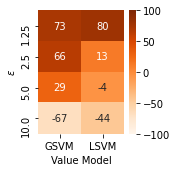

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2.5, 2.5))  # Size for only 4 plots, 1 by 4
ax = sns.heatmap(np.array([[73, 80],
                           [66, 13],
                           [29, -4],
                           [-67, -44]
                          ]), 
                 annot=True, 
                 cmap=cmaps[4], 
                 xticklabels=['GSVM', 'LSVM'],
                 yticklabels=[j for j in epsilons],
                 vmax=100, # This value is data dependent
                 vmin=-100, # This value is data dependent
                 ax = axs)
ax.set_xlabel('Value Model')
ax.set_ylabel(r'$\epsilon$')
#ax.set_title(f'Title')
plt.tight_layout()

## Inspecting pruning, 1st pass and 2nd pass

In [12]:
def plot_pruning(domain):
    summary_pruning = {}
    for eps in epsilons:
        #print(f"\n{eps}\n")
        data = pd.concat([pd.read_csv(f"../value_models_experiments/{domain}/worlds_results/world{i}/eps_{eps}/pruning_evolution_summary.csv") for i in configurations[domain]['samples']])
        summary_pruning[eps] = {}
        for num_pass in [0, 1, 2]:
            #print(f"\n\t{num_pass} \n")
            first_pass = data[data['end_of_iteration'] == num_pass]['pruned_1st_pass']
            secon_pass = data[data['end_of_iteration'] == num_pass]['pruned_2nd_pass']
            #print(first_pass)
            mean_first, lb_first, ub_first, width_first = compute_conf_interval(first_pass)
            if math.isnan(width_first):
                width_first = 0

            #print(secon_pass)
            mean_secon, lb_secon, ub_secon, width_secon = compute_conf_interval(secon_pass)
            if math.isnan(width_secon):
                width_secon = 0
            summary_pruning[eps][num_pass] = {'mean_first' : mean_first, 
                                              'width_first': width_first,
                                              'mean_secon' : mean_secon,
                                              'width_secon' : width_secon}
        #pprint.pprint(summary)

    bar_width = 0.25
    colors = {1.25: 'blue', 2.5: 'green', 5.0 : 'orange', 10.0 : 'black'}
    fig, ax = plt.subplots()
    for i, eps in enumerate(epsilons):
        summary = summary_pruning[eps]
        t = i
        j = 0
        the_alpha = 1.0
        for num_pass in [0, 1, 2]:
            plt.bar(x=[i + t + j, i + bar_width + t + j], 
                    height=[summary[num_pass]['mean_first'], summary[num_pass]['mean_secon']], 
                    yerr=[summary[num_pass]['width_first'], summary[num_pass]['width_secon']],
                    width=bar_width,
                    label=f'{eps}',
                    color=colors[eps],
                    alpha=the_alpha)
            t += bar_width
            j += bar_width
            the_alpha -= 0.4

    ax.set_xticks([bar_width, 2 + bar_width, 4 + bar_width, 6 + bar_width])
    ax.set_xticklabels(epsilons)
    ax.set_yscale('log')
    ax.set_ylim(bottom=1.0, top=10 ** 6)
    ax.set_xlabel(f'$\epsilon$')
    plt.title(f'{domain}')
    plt.rcParams.update({'font.size': 14})
    #plt.legend()


/Users/enriqueareyan/Documents/workspace/competitive_equilibria/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/enriqueareyan/Documents/workspace/competitive_equilibria/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


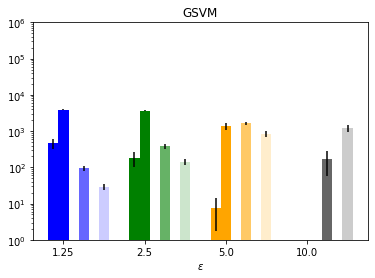

In [13]:
plot_pruning('GSVM')

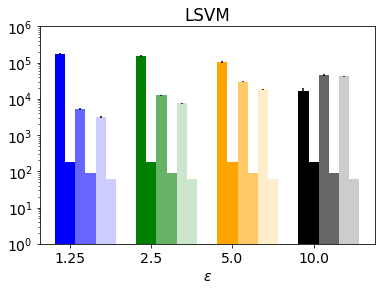

In [14]:
plot_pruning('LSVM')